# download data and copy to drive

In [1]:
!wget 'https://storage.googleapis.com/wandb_datasets/nature_12K.zip'
!unzip 'nature_12K.zip'

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [2]:
# !cp -av 'inaturalist_12K' 'drive/My Drive/DL_assignments/assignment2'

# code

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%pip install -qq wandb
import glob
import numpy as np
import math
import pandas as pd
from random import sample
import random
from bisect import bisect
from __future__ import print_function
import keras
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras import backend as K
# import wandb
# from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
%matplotlib inline 
import cv2
random.seed(7)


     |████████████████████████████████| 2.1MB 8.5MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 133kB 55.4MB/s 
     |████████████████████████████████| 163kB 48.7MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 


In [4]:
img_size = 300
n_class = 10
# path = "drive/My Drive/DL_assignments/assignment2/inaturalist_12K/"
path = "inaturalist_12K/"


In [5]:
def create_model(n_filters,dropout,batchnormalize):

  input_shape = (img_size,img_size,3)
  kernel_size = (3,3)
  pool_size = (3,3)
  lr = 0.0005
  model = Sequential()

  model.add(Conv2D(n_filters[0], kernel_size=kernel_size,
                  activation='relu', kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
                  input_shape=input_shape))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool_size))

  model.add(Conv2D(n_filters[1], kernel_size=kernel_size,kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
                  activation='relu'))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(dropout))

  model.add(Conv2D(n_filters[2], kernel_size=kernel_size,kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
                  activation='relu'))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(dropout))


  model.add(Conv2D(n_filters[3], kernel_size=kernel_size,kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
                  activation='relu', padding='same' ))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(dropout))

  model.add(Conv2D(n_filters[3], kernel_size=kernel_size,kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
                  activation='relu',padding='same'))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=pool_size))
  model.add(Dropout(dropout))

  # model.add(Conv2D(n_filters[3], kernel_size=kernel_size,kernel_regularizer=l2(lr), bias_regularizer=l2(lr),
  #                 activation='relu'))
  # if (batchnormalize) : model.add(BatchNormalization())
  # model.add(MaxPooling2D(pool_size=pool_size))
  # model.add(Dropout(dropout))


  model.add(Flatten())

  model.add(Dense(256, activation='relu',kernel_regularizer=l2(lr), bias_regularizer=l2(lr)))
  if (batchnormalize) : model.add(BatchNormalization())
  model.add(Dropout(dropout))

  model.add(Dense(256, activation='relu',kernel_regularizer=l2(lr), bias_regularizer=l2(lr)))
  if (batchnormalize) : model.add(BatchNormalization())

  model.add(Dense(n_class, activation='softmax'))

  return model

# train

In [ ]:
def train():
  run = wandb.init()
  c = run.config
  name = "f"+'_'.join(map(str,c.filters))+"_d_"+str(c.dropout)+"_bn_"+str(c.batchnormalize)+"_aug_"+str(c.aug)+"_bs_"+str(c.batch_size)
  run.name = name
  print(name)
 
  bs = c.batch_size
  epochs = 30
  
  # create generator
  datagen = None
  if (c.aug):
    datagen = ImageDataGenerator(validation_split=0.1,rescale=1.0/255.0,rotation_range=90)
  else:
    datagen = ImageDataGenerator(validation_split=0.1,rescale=1.0/255.0)
  train = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                         seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="training")
  val = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                    seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="validation")
  
  labels = list(train.class_indices.keys())

  datagen_t = ImageDataGenerator(rescale=1.0/255.0)
  test = datagen_t.flow_from_directory(path+'val/',target_size=(img_size,img_size),
                                     seed=10,batch_size=1,shuffle=True,class_mode="categorical",color_mode="rgb")
  
  model = create_model(c.filters,c.dropout,c.batchnormalize)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  
  model.fit(train,
   epochs = epochs,
	steps_per_epoch= len(train) ,
  validation_data=val,
  validation_steps=len(val),
  verbose = 1,
  callbacks=[WandbCallback(),es])
  
  loss,acc = model.evaluate(test,callbacks=[WandbCallback()])
  wandb.log({'test_acc' : round(acc*100,2),'test_loss' : round(loss,3)})
  
  
  return




In [ ]:
sweep_config={
    'method' : 'random' ,
    'metric' : { 'name' : 'val_accuracy' , 'goal' : 'maximize' } ,
    'parameters' : {
        'filters' : { 'values' : [[64,64,64,32],[64,64,32,32],[64,32,32,16],[64,32,16,16]] },
        'dropout' : { 'values' : [0.1,0.2]},
        'batch_size' : {'values' : [128,64]},
        'batchnormalize' : {'values' : ['True' ,'False']},
        'aug' : {'values' : ['True' ,'False']}
    }
}


In [ ]:
sweepid = wandb.sweep(sweep_config,project="dl_a2",entity ="kkk")
wandb.agent(sweepid,train)

NameError: ignored

# extra


In [ ]:
  bs = 64
  epochs = 3
  f = [64,32,32,16]
  d = 0.1
  bn = True
  
  datagen = ImageDataGenerator(validation_split=0.1,rescale=1.0/255.0,rotation_range=90)
  train = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                         seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="training")
  val = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                    seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="validation")
  
  labels = list(train.class_indices.keys())

  datagen_t = ImageDataGenerator(rescale=1.0/255.0)
  test = datagen_t.flow_from_directory(path+'val/',target_size=(img_size,img_size),
                                     seed=10,batch_size=1,shuffle=True,class_mode="categorical",color_mode="rgb")
  
  model = create_model(f,d,bn)
  # model.summary

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  # print(999//128)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

  model.fit(train,
   epochs = epochs,
	steps_per_epoch= len(train),
  validation_data=val,
  validation_steps=len(val),
  verbose = 1,callbacks=[es])
  
  loss,acc = model.evaluate(test)
  print(loss,acc)

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/3
141/141 [==============================] - 270s 2s/step - loss: 2.7621 - accuracy: 0.1557 - val_loss: 2.6099 - val_accuracy: 0.1001
Epoch 2/3
141/141 [==============================] - 267s 2s/step - loss: 2.4369 - accuracy: 0.2021 - val_loss: 2.9194 - val_accuracy: 0.0951
Epoch 3/3
2000/2000 [==============================] - 26s 13ms/step - loss: 2.8124 - accuracy: 0.1105
2.81243634223938 0.11050000041723251


In [ ]:
labels = val.class_indices
label_list = list(val.class_indices)
print(labels)
print(label_list)

{'Amphibia': 0, 'Animalia': 1, 'Arachnida': 2, 'Aves': 3, 'Fungi': 4, 'Insecta': 5, 'Mammalia': 6, 'Mollusca': 7, 'Plantae': 8, 'Reptilia': 9}
['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


# q4


In [ ]:
def load_data():
  folders=glob.glob(path + "train/*")
  names = []
  ll = len(path)
  for i in folders:
    names.append(i[ll+6:])

  d = labels  

  
  # train = []
  # ytrain = []
  # for i in folders:
  #   temp = glob.glob(i+"/*")
  #   temp1 = [d[i[ll+6:]]] * len(temp)
  #   ytrain += temp1
  #   print(i)
  #   for j in temp:
  #     img = cv2.imread(j)
  #     img = cv2.resize(img,(img_size,img_size))
  #     train.append(img)
  
  folders=glob.glob(path + "val/*")
  test = []
  ytest = []
  for i in folders:
    temp = glob.glob(i+"/*")
    temp1 = [d[i[ll+4:]]] * 3
    ytest += temp1
    for j in temp[1:4]:
      img = cv2.imread(j)
      img = cv2.resize(img,(img_size,img_size))
      test.append(img)

  # train = np.asarray(train).astype('float32')
  # train = train / 255

  test = np.asarray(test).astype('float32')
  test = test / 255
  

  return  test ,ytest

In [ ]:
x,y = load_data()


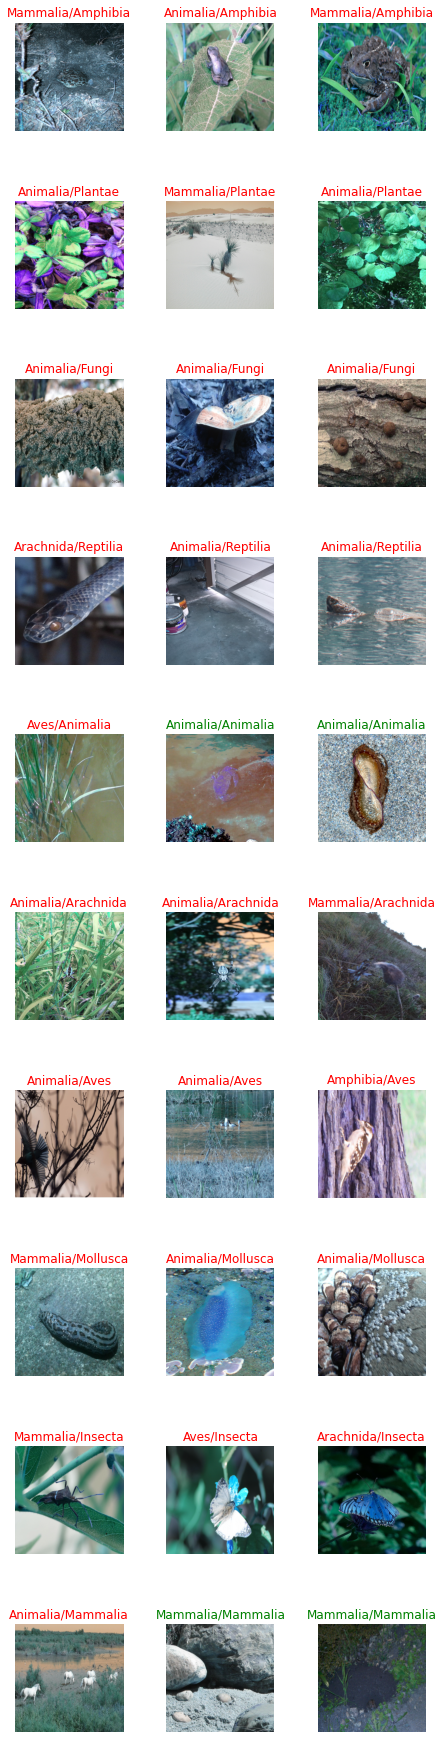

In [ ]:
t = model.predict(x)
t = t.argmax(axis=-1)
# t1 = np.argmax(y,axis=-1)
plt.figure(figsize=(30,30))
plt.subplots_adjust(left=0.01,
                    bottom=0.1, 
                    right=0.2, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
for i in range(len(x)):
  temp = label_list[t[i]]
  plt.subplot(10,3,i+1)
  plt.imshow(x[i])
  if(temp == label_list[y[i]]):
    c = 'g'
  else:
    c = 'r'
  plt.title(temp+"/"+label_list[y[i]],color = c)
  plt.axis("off")
  



In [ ]:
# b
layer_w = model.layers[0].get_weights()
print(layer_w[0].shape[-1])
plt.figure(figsize=(20,20))
for i in range(layer_w[0].shape[-1]):
  plt.subplot(8,8,i+1)
  plt.imshow(layer_w[0][:,:,:,i][:,:,:])
  plt.axis("off")



(1, 298, 298, 64)


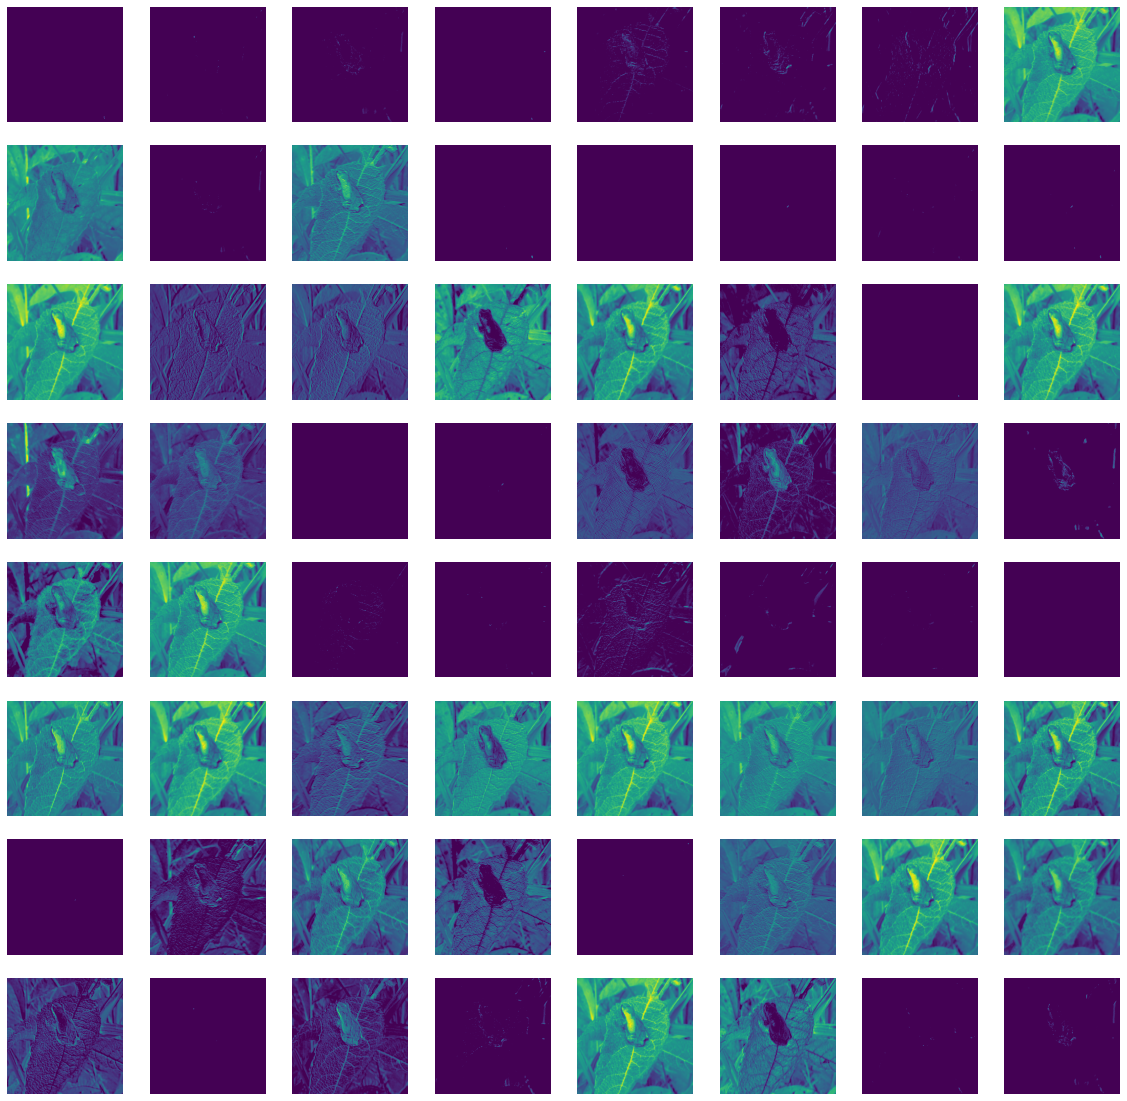

In [ ]:
from keras.models import Model
layer_out = [i.output for i in model.layers]
# m = Model(inputs = model.inputs , outputs = model.layers[0].output)
m = Model(inputs = model.inputs , outputs = layer_out)
# m.summary()
feature_map = m.predict(np.reshape(x[1],(1,300,300,3)))
l = 1
print(np.shape(feature_map[l]))
plt.figure(figsize=(20,20))
for i in range(np.shape(feature_map[l])[-1]):
  plt.subplot(8,8,i+1)
  plt.imshow(feature_map[l][0,:,:,i])
  plt.axis("off")


# q5

In [40]:

from keras.applications import vgg16
from keras.applications import resnet50
from keras.applications import inception_v3
from keras.models import Model


In [44]:
def load_pretrained_model(name):
  p_model = globals()[name+"."+name.upper()](weights='imagenet',include_top=False,input_tensor = Input(shape=(img_size, img_size, 3)))
  for layer in p_model.layers:
	  layer.trainable = False

  flat = Flatten()(p_model.layers[-1].output)
  d1 = Dense(1024, activation='relu')(flat)
  # dr = Dropout(0.2)(d1)
  output = Dense(10, activation='softmax')(dr)
  p_model = Model(inputs=p_model.inputs, outputs=output)
  # p_model.summary()
  return p_model
  

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0   

In [47]:
def train_pretrain_model(name):
  bs = 64
  epochs = 3

  
  datagen = ImageDataGenerator(validation_split=0.1,preprocessing_function= globals()[name+"."+"preprocess_input"])
  train = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                         seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="training")
  val = datagen.flow_from_directory(path+'train/',target_size=(img_size,img_size),
                                    seed=10,batch_size=bs,shuffle=True,class_mode="categorical",color_mode="rgb",subset="validation")
  
  labels = list(train.class_indices.keys())

  datagen_t = ImageDataGenerator(preprocessing_function= globals()[name+"."+"preprocess_input"])
  test = datagen_t.flow_from_directory(path+'val/',target_size=(img_size,img_size),
                                     seed=10,batch_size=1,shuffle=True,class_mode="categorical",color_mode="rgb")
  
  model = load_pretrained_model(name)
  # model.summary

  model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
  # print(999//128)

  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

  model.fit(train,
   epochs = epochs,
	steps_per_epoch= len(train),
  validation_data=val,
  validation_steps=len(val),
  verbose = 1,callbacks=[es])
  
  loss,acc = model.evaluate(test)
  print(loss,acc)

In [48]:
train_pretrain_model('vgg16')

KeyError: ignored

In [51]:
vgg16.preprocess_input()

TypeError: ignored